# Use GANs to create art Mini-Project

* Kaggle Competition [I’m Something of a Painter Myself](https://www.kaggle.com/competitions/gan-getting-started/overview)

In [13]:
# Packages
!pip install tensorflow_addons
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

# Tensorflow config
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [14]:
# Check if GPU is used
tf.config.list_physical_devices('GPU')

[]

The code below sets the model training strategy according to the processor type, and outputs the processor details. Kaggle's GPU T4 X2 and TPU VM v3-8 were not compatible with TensorFlow due to incompatibilities with CUDA version 12.2 and possibly with cuDNN. Using Kaggle's GPU P100 returned warning messages that hinted at compatibility problems, but the model compiled and trained without issue.

[Ref](https://www.kaggle.com/code/stevenhobbs74/hobbs-monet-cyclegan#INTRODUCTION-&-SETUP)

In [15]:
# Kaggle notebook setting
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.config.experimental_connect_to_cluster(tpu) # Connects to the given cluster
    tf.tpu.experimental.initialize_tpu_system(tpu) # Initializes the TPU system
    strategy = tf.distribute.TPUStrategy(tpu) # TPU distribution strategy
    print('Running on TPUs')

except ValueError:
    print("TPU not available.")
    if tf.config.list_physical_devices('GPU'):
        strategy = tf.distribute.MirroredStrategy()
        print("Running on GPU.")
    else:
        strategy = tf.distribute.get_strategy()
        print("Running on CPU.")

print('Number of accelerators (CPU, GPU, or TPU):', strategy.num_replicas_in_sync)
print("Tensorflow Version:", tf.__version__)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('Not using a high-RAM runtime.')
else:
    print('Using a high-RAM runtime!')

TPU not available.
Running on CPU.
Number of accelerators (CPU, GPU, or TPU): 1
Tensorflow Version: 2.15.0
Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime.


Goal:

The primary objective of this project is to train a Generative Adversarial Network (GAN) capable of generating images in the style of Monet. This involves the development and training of at least two neural network models: a generator and a discriminator. The generator model is tasked with creating images resembling Monet paintings, while the discriminator model aims to distinguish between real Monet paintings and generated images. A key highlight of this project is the exploration of two different architectures with distinct designs and hyperparameter settings.

#Data and Project Description:

#Dataset Composition:

The training dataset consists of 300 Monet paintings and 7,028 photos for style transformation. All images are sized 256x256 pixels and are available in both JPEG and TFRecord formats.
CycleGAN:

CycleGAN is the chosen model for this project, primarily utilized for solving the image-to-image translation problem. Unlike traditional methods that require paired input-output images for training, CycleGAN can learn the mapping between input and output images without such pairs. This is particularly advantageous given the limited availability of paired examples in our dataset.
TFRecord Format:

TFRecord is TensorFlow's proprietary binary record format. It offers several advantages, including reduced disk space usage and faster read/write times compared to traditional formats. TFRecord also facilitates the integration of multiple datasets into a single dataset, streamlining data loading and preprocessing operations. This is especially beneficial when dealing with large datasets, as it allows for efficient memory usage by loading only the necessary portions of the TFRecord for processing.







# Data preprocessing

A. Load and Data Preprocessing
In this section, we will utilize Tensorflow's TFRecord files and employ the tf.data.Dataset API to load and parse the data. The data input pipeline will encompass the following tasks:

Parsing the Data: This involves converting the serialized TFRecords into TensorFlow dictionaries.
Decoding the TensorFlow String: Decode the TensorFlow string into a 3D tensor.
Setting Data Type: Set the data type to float32.
Scaling the Data: Scale the data to a range of [-1, 1].
Reshaping the Data: Reshape the data to dimensions of 256 x 256.
These preprocessing steps ensure that the data is properly formatted and prepared for training the GAN model.








In [16]:
image = Path.home() /"Desktop/gan-getting-started"
MONET = tf.io.gfile.glob(str(image.as_posix() + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET))

PHOTO = tf.io.gfile.glob(str(image.as_posix() + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO))

Monet TFRecord Files: 0
Photo TFRecord Files: 0


In [17]:
# Data preprocessing
image_size = [256, 256]

def image_decoder(image_input):
    image = tf.image.decode_jpeg(image_input, channels=3)
    # Scale the images to [-1, 1]
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*image_size, 3])
    return image

def read_tfrecord(example):
    # Decode the TFRecord
    tfrecord_format = {
        "image_name" : tf.io.FixedLenFeature([], tf.string),
        "image" : tf.io.FixedLenFeature([], tf.string),
        "target" : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = image_decoder(example['image'])
    return image

# Extract the image from files
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [18]:
# Load images
monet_load = load_dataset(MONET, labeled=True)
photo_load = load_dataset(PHOTO, labeled=True)

In [20]:
try:
    example_monet = next(iter(monet_load))
except StopIteration:
    print("End of dataset sequence reached.")

try:
    example_photo = next(iter(photo_load))
except StopIteration:
    print("End of dataset sequence reached.")


End of dataset sequence reached.
End of dataset sequence reached.


NameError: name 'example_photo' is not defined

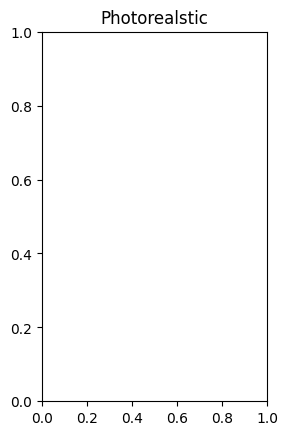

In [21]:
plt.subplot(121)
plt.title('Photorealstic')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet photos')
plt.imshow(example_monet[0] * 0.5 + 0.5)

### B. Data augmentation

* For tasks like transferring the style of one image to another, it's crucial to approach data augmentation with caution. Drastically altering colors, such as brightness, contrast, or saturation, may confuse the machine and hinder its ability to learn the original style effectively. Therefore, it's advisable to limit color modifications and instead focus on non-color-related transformations like flipping, rotating, or cropping the images. This approach allows the machine to concentrate on learning the fundamental style nuances present in the original data. Additionally, introducing some randomness during augmentation helps introduce diversity and mitigate the risk of overfitting.








In [ ]:
# Data augmentation for the images
def aug_data(image_input):
    # Use random choices for augmentations to introduce variety and prevent overfitting.
    spatial_r = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    rotate_r = tf.random.uniform([], 0, 1.0, dtype=tf.float32)

    # Apply 90 degrees rotations
    if rotate_r > .8:
        image_input = tf.image.rot90(image_input, k=3)  # Rotate 270º
    elif rotate_r > .6:
        image_input = tf.image.rot90(image_input, k=2)  # Rotate 180º
    elif rotate_r > .4:
        image_input = tf.image.rot90(image_input, k=1)  # Rotate 90º

    # Apply flips
    image_input = tf.image.random_flip_left_right(image_input)
    image_input = tf.image.random_flip_up_down(image_input)

    # Transpose operation
    if spatial_r > .75:
        image_input = tf.image.transpose(image_input)

    # Focus on a 128x128 pixel area to promote learning from different image details.
    image_input = tf.image.random_crop(image_input, size=[128, 128, 3])

    return image_input


In [ ]:
monet_dataset = monet_load.map(aug_data, num_parallel_calls=AUTOTUNE)
photo_dataset = photo_load.map(aug_data, num_parallel_calls=AUTOTUNE)

monet_dataset = monet_dataset.batch(1).shuffle(1024).prefetch(AUTOTUNE)
photo_dataset = photo_dataset.batch(1).shuffle(1024).prefetch(AUTOTUNE)

## Structure Design

* What is U-Net?
The CycleGAN architecture incorporates a U-Net structure, which is renowned for its effectiveness in image segmentation tasks. Before delving into the specifics of the U-Net implementation, let's first understand the key principles behind the U-Net architecture.

#### 1: Capturing Details (Contracting Path):

  * Similar to a detective gathering clues, U-Net begins its analysis by scrutinizing the image in detail. It employs a series of convolutional layers, acting as magnifying glasses, to zoom in and capture crucial features such as shapes, edges, and textures. This initial phase of U-Net, known as the contracting path, progressively extracts essential details from the image while maintaining their integrity as it delves deeper.

#### 2  Locating Precise Areas (Expanding Path):

* Having gained a comprehensive understanding of the image's intricacies, U-Net proceeds to pinpoint specific regions of interest. Here, U-Net's second superpower, the expanding path, comes into play. Through specialized techniques, it enhances the resolution of extracted information and merges it with the detailed features obtained earlier. This process resembles overlaying precise location markings onto a detailed map, enabling U-Net to accurately identify and segment areas of interest within the image.

###Summary:

During training, U-Net undergoes rigorous challenges. It is presented with real images containing segmented areas and tasked with predicting these segmentations independently. In the event of errors, U-Net receives corrective feedback, nudging it towards improved performance. This competitive interaction between U-Net and the training data fosters its growth into a proficient segmentation expert.

In summary, U-Net's amalgamation of detailed feature extraction and precise localization renders it an invaluable tool for addressing image segmentation tasks with remarkable accuracy and efficiency.








* Implemented Structure

In constructing the unet-style generator, we'll begin by defining functions for downsampling and upsampling the input images. This approach is illustrated in both the Tensorflow CycleGAN Tutorial and Amy Jang's CycleGAN tutorial, both of which offer valuable insights. Some of the code presented here is adapted from these tutorials.

## Downsampling:
Downsampling involves reducing the image's two-dimensional size (width and height) by a factor determined by the stride. The stride specifies the distance the filter moves between applications. With a stride set to 2, the filter is applied to every other pixel, effectively halving both the width and height.

## Upsampling:
Conversely, upsampling increases the dimensions of the image, providing a higher resolution output.

* Both tutorials opted for instance normalization from Tensorflow Addons (tfa.layers.InstanceNormalization) instead of the more common batch normalization (tf.keras.layers.BatchNormalization). Since Tensorflow no longer natively supports instance normalization, we'll utilize group normalization (tensorflow.keras.layers.GroupNormalization). To achieve the same effect as InstanceNormalization, we'll set groups = -1 or groups equal to the number of input channels. For more information about GroupNormalization, please refer to the Keras V2 document and Keras V3 document.

The downsample and upsample functions combine standard layers (Conv2D/Conv2DTranspose, GroupNormalization, Dropout, and LeakyReLU/ReLU) into blocks, which are concise and facilitate easier manipulation, while still allowing specification of filter numbers and kernel sizes.









In [ ]:
CHANNELS = 3

def downsample_func(filters, kernel_size=4, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(
        filters, kernel_size,
        strides=2,
        padding='same',
        kernel_initializer=initializer,
        use_bias=False))

    if apply_instancenorm:
        result.add(layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result


def upsample_func(filters, kernel_size=4, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    return_result = keras.Sequential()
    return_result.add(layers.Conv2DTranspose(
        filters, kernel_size,
        strides=2,
        padding='same',
        kernel_initializer=initializer,
        use_bias=False))

    return_result.add(layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init))

    if apply_dropout:
        return_result.add(layers.Dropout(0.5))

    return_result.add(layers.ReLU())

    return return_result


### A. Build

The generator is constructed using a combination of different layers along with skip connections:

## Convolutional Layers (Downsample) or Transpose Convolutional Layers (Upsample):
  * These layers either extract features from the image (downsampling) or inject features into the image (upsampling), aiding in tasks such as identifying edges or adding details.

## Group Normalization:
  * Incorporated to enhance the learning process of the network.

## Activation Function (ReLU or LeakyReLU):
   * Adds non-linearity to the process, enabling the network to learn complex patterns effectively.
   
## Dropout Layer:
   * This layer randomly drops some information during training to prevent overfitting, thereby making the model more adaptable to varying scenarios.


The final layer utilizes a different activation function (tanh) to produce the generated image with values in the range of  -1 and 1.

#Shortcut Connections (Skip Connections):

 * Skip connections serve as useful reminders of important details from earlier stages. They establish direct connections between information from earlier steps in the generator to later stages, aiding in retaining crucial details about the original image and preventing loss of information across multiple steps. These connections are depicted as curved arrows in the diagram following the function definitions.








In [ ]:
# Build the generator
def Generator():
    inputs = layers.Input(shape=[256, 256, 3])
    up_stack = [
        upsample_func(512, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample_func(512, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample_func(512, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample_func(512),  # (bs, 16, 16, 1024)
        upsample_func(256),  # (bs, 32, 32, 512)
        upsample_func(128),  # (bs, 64, 64, 256)
        upsample_func(64),  # (bs, 128, 128, 128)
    ]
    down_stack = [
        downsample_func(64, apply_instancenorm=False),  # (bs, 128, 128, 64), bs = batch size
        downsample_func(128),  # (bs, 64, 64, 128)
        downsample_func(256),  # (bs, 32, 32, 256)
        downsample_func(512),  # (bs, 16, 16, 512)
        downsample_func(512),  # (bs, 8, 8, 512)
        downsample_func(512),  # (bs, 4, 4, 512)
        downsample_func(512),  # (bs, 2, 2, 512)
        downsample_func(512),  # (bs, 1, 1, 512)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                   strides=2,
                                   padding='same',
                                   kernel_initializer=initializer,
                                   activation='tanh')  # (bs, 256, 256, 3)

    index = inputs

    # Downsampling through the model
    skips = []
    for down_unit in down_stack:
        index = down_unit(index)
        skips.append(index)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        index = up(index)
        index = layers.Concatenate()([index, skip])

    index = last(index)

    return keras.Model(inputs=inputs, outputs=index)


# Discriminator
The discriminator comprises three primary layers:

###Downsampling Layers:
 * These layers utilize three "downsample" blocks to progressively extract more complex features from the input image. They start with low-level details like edges and colors and proceed to capture higher-level abstract features in deeper layers.

###Bottleneck Layers:

* Zero Padding Layer:
 ##### This layer adds padding to the feature maps generated by the preceding downsampling layer (typically referred to as 'down3'). The padding ensures that the output size remains unchanged after subsequent convolution operations.

* Convolutional Layer

* Group Normalization

* LeakyReLU

 ####### This bottleneck layer, consisting of convolution, normalization, and activation, serves as the discriminator's core. It is responsible for extracting high-level features crucial for discerning between real and fake images.

### Output Layer:

* Zero Padding Layer
* Convolutional Layer
#### The output layer produces a smaller 2D image where higher pixel values indicate a classification as real, while lower values suggest a classification as fake.








In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    # Input layer
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp

    # Downsampling layers
    down1 = downsample_func(64, apply_instancenorm=False)(x)  # (bs, 128, 128, 64)
    down2 = downsample_func(128)(down1)  # (bs, 64, 64, 128)
    down3 = downsample_func(256)(down2)  # (bs, 32, 32, 256)

    # Bottleneck layers
    zero_pad1 = layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = layers.Conv2D(
        512, 4,
        strides=1,
        kernel_initializer=initializer,
        use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    norm1 = tfa.layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init)(conv)
    leaky_relu = layers.LeakyReLU()(norm1)

    # Output layer
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)
    fin_output = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=fin_output)


### C. Architecture diagram & model summary

In [ ]:
# strategy = tf.distribute.get_strategy()
# APPLY DISTRIBUTION STRATEGY TO MODELS
with strategy.scope():
    monet_gen = Generator() # transforms photos to Monet-esque paintings
    photo_gen = Generator() # transforms Monet paintings to be more like photos

    monet_disc = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_disc = Discriminator() # differentiates real photos and generated photos

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
print("Monet Generator Model Summary:", monet_gen.summary())

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [ ]:
print("Monet Discriminator Model Summary:", monet_disc.summary())

In [ ]:
to_monet = monet_gen(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

###  CycleGAN model

The CycleGAN architecture is structured around a subclass of tf.keras.Model, facilitating training via the fit() method for image translation between Monet paintings and photos. It comprises two key components:

####  **Generators**:
 * Two generators (m_gen and p_gen) are responsible for translating images between Monet paintings and photos.

####  **Discriminators**:

  * Two discriminators (m_disc and p_disc) distinguish between real Monet paintings/photos and generated ones.

The training process involves several steps:

1. **Generator Training**: Fake images are generated (Monet paintings from photos and photos from Monet paintings).

2. **Cycle Consistency**: The generated images are cycled back to their original domain (photo -> fake Monet -> photo or Monet -> fake photo -> Monet), ensuring resemblance to the originals.

3. **Identity Loss**: Generators are penalized for significantly altering real images during translation, aiming to preserve some identity.

4. **Discriminator Training**: Discriminators aim to differentiate between real and fake images, while generators aim to fool them.

The training loop iterates through the dataset, calculating losses for generators and discriminators based on the outlined strategies. Gradients are then computed and applied to update the weights of generators and discriminators, enhancing their performance over time.








In [ ]:
import tensorflow as tf
from tensorflow import keras

class CycleGan(keras.Model):
    def __init__(
        self,
        monet_gen,
        photo_gen,
        monet_disc,
        photo_disc,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_gen
        self.p_gen = photo_gen
        self.m_disc = monet_disc
        self.p_disc = photo_disc
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)


            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))

        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))


        return {
              "photo_disc_loss": photo_disc_loss,
             "photo_gen_loss": total_photo_gen_loss,


            "monet_gen_loss": total_monet_gen_loss,
            "monet_disc_loss": monet_disc_loss,
        }


###  Loss functions

* The utilization of strategy.scope() in Tensorflow directs the distribution of the model's operations as per the strategy defined in the "Kaggle notebook setting" section following the package imports.

* The significance of each loss function has been elucidated in the preceding section.








In [ ]:
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, lambda_const):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return lambda_const * loss1

def identity_loss(real_image, same_image, lambda_const):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return lambda_const * 0.5 * loss




```

## Modeling

In [ ]:
# Define optimizer
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
# Instantiate the model
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_gen, photo_gen, monet_disc, photo_disc
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [ ]:
# Training
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_dataset, photo_dataset)),
    epochs=1
)



```
# This is formatted as code
```

##  submit

In [ ]:
import PIL
! mkdir ../images

In [ ]:
i = 1
for img in photo_dataset:
    prediction = monet_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

After several iterations, the initial notebook achieved a score of around 60. Subsequent attempts to improve the score through techniques such as data augmentation and increasing training epochs actually yielded worse results. It's evident that merely tweaking these parameters wasn't sufficient for enhancing performance. It's clear that adjusting the model architecture is necessary for further improvement.

Throughout this project, various techniques have been applied to enhance the performance of CycleGAN:

* Utilizing InstanceNormalization
* Implementing a DCGAN structure
* Employing a small batch size for training
* Adopting the Adam optimizer
* Integrating skip connections
Due to constraints on GPU and TPU usage on Kaggle, further experimentation with hyperparameter tuning or alternative structures wasn't feasible. However, I intend to explore these avenues locally where resource limitations are less restrictive.






